# colab settings:

In [0]:
!pip install PyDrive

    100% |████████████████████████████████| 993kB 25.8MB/s 
  Stored in directory: /root/.cache/pip/wheels/fa/d2/9a/d3b6b506c2da98289e5d417215ce34b696db856643bad779f4
Successfully built PyDrive


In [0]:
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [0]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
# download to Colab from Google Drive:
# https://drive.google.com/open?id=YOUR_FILE_ID
download = drive.CreateFile({'id': '10AWC5jfxqdDXode3_1vkDKZpWVeAROV4'}) # 'id': 'YOUR_FILE_ID'
download.GetContentFile('dataset.tar')

In [0]:
# upload to Google Drive from Colab:
upload = drive.CreateFile({'title': 'DRIVE.txt'})
upload.SetContentFile('FILE_ON_COLAB.txt')
upload.Upload()

In [0]:
!ls

adc.json  dataset.tar  sample_data


In [0]:
!ls "/content/drive/My Drive/Colab Notebooks/Project31/"

CNN_HOG.ipynb  LinearSVC_HOG.npy	       model_wieghts_batch4_epochs16.h5
dataset.tar    LinkReview.docx		       README.md
INRIAPerson    model_keras_batch4_epochs16.h5  SVM_HOG.ipynb


In [0]:
!tar -xvf dataset.tar

INRIAPerson/
INRIAPerson/train_64x128_H96/
INRIAPerson/train_64x128_H96/pos.lst
INRIAPerson/train_64x128_H96/neg
INRIAPerson/train_64x128_H96/neg.lst
INRIAPerson/train_64x128_H96/pos/
INRIAPerson/train_64x128_H96/pos/crop001138b.png
INRIAPerson/train_64x128_H96/pos/person_and_bike_010b.png
INRIAPerson/train_64x128_H96/pos/person_187d.png
INRIAPerson/train_64x128_H96/pos/crop001274b.png
INRIAPerson/train_64x128_H96/pos/crop001519b.png
INRIAPerson/train_64x128_H96/pos/person_and_bike_075b.png
INRIAPerson/train_64x128_H96/pos/person_304e.png
INRIAPerson/train_64x128_H96/pos/person_097c.png
INRIAPerson/train_64x128_H96/pos/crop001147a.png
INRIAPerson/train_64x128_H96/pos/crop001692d.png
INRIAPerson/train_64x128_H96/pos/person_425f.png
INRIAPerson/train_64x128_H96/pos/person_258a.png
INRIAPerson/train_64x128_H96/pos/crop001524a.png
INRIAPerson/train_64x128_H96/pos/person_185c.png
INRIAPerson/train_64x128_H96/pos/crop001011b.png
INRIAPerson/train_64x128_H96/pos/crop001553a.png
INRIAPerson/tr

# Train CNN classifier from keras on INRIA dataset

Tutorial: https://towardsdatascience.com/image-detection-from-scratch-in-keras-f314872006c9

Code on git: https://github.com/risenW/medium_tutorial_notebooks/blob/master/dogs-vs-cats-keras-implementation.ipynb


In [0]:
from skimage.io import imread
from skimage import data, color
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

import numpy as np
import os

import gc # garbage collector

from keras import layers
from keras import models
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import img_to_array, load_img

Using TensorFlow backend.


In [0]:
# define parameters of HOG feature extraction
# change them if necessary to orientations = 8, pixels per cell = (16,16), cells per block to (1,1) for weaker HOG
orientations = 9
pixels_per_cell = (8, 8)
cells_per_block = (2, 2)
threshold = .3
# 9 * 4(16x16 / 8x8) = 36 
# 36 * 105 (7 * 15 - pos of 16x16) 3780

# define size for train and test data
PERSON_WIDTH = 64
PERSON_HEIGHT = 128
leftop_train = [16, 16]
rightbottom_train = [16 + PERSON_WIDTH, 16 + PERSON_HEIGHT]
leftop_test = [3, 3]
rightbottom_test = [3 + PERSON_WIDTH, 3 + PERSON_HEIGHT]

In [0]:
# COLAB
# define path to images:

#train_pos_img_dir = '/content/drive/My Drive/Colab Notebooks/Project31/INRIAPerson/train_64x128_H96/pos/'
#train_neg_img_dir = '/content/drive/My Drive/Colab Notebooks/Project31/INRIAPerson/train_64x128_H96/neg/'
#test_pos_img_dir = '/content/drive/My Drive/Colab Notebooks/Project31/INRIAPerson/test_64x128_H96/pos/'
#test_neg_img_dir = '/content/drive/My Drive/Colab Notebooks/Project31/INRIAPerson/test_64x128_H96/neg/'



In [0]:
# JUPYTER or COLAB (dataset.tar)
# define path to images:

train_pos_img_dir = 'INRIAPerson/train_64x128_H96/pos/'
train_neg_img_dir = 'INRIAPerson/train_64x128_H96/neg/'
test_pos_img_dir = 'INRIAPerson/test_64x128_H96/pos/'
test_neg_img_dir = 'INRIAPerson/test_64x128_H96/neg/'

In [0]:
# read the image files:
train_pos_images = os.listdir(train_pos_img_dir)
train_neg_images = os.listdir(train_neg_img_dir)
test_pos_images = os.listdir(test_pos_img_dir)
test_neg_images = os.listdir(test_neg_img_dir)

trainData = []
testData = []
trainLabels = []
testLabels = []

# loading train data
print('loading ' + str(len(train_pos_images)) + ' positive images [Train]')
for train_pos_image in train_pos_images:
    pos_img = data.imread(train_pos_img_dir + train_pos_image, as_gray=False)
    pos_roi = pos_img[leftop_train[1]:rightbottom_train[1], leftop_train[0]:rightbottom_train[0]]
    trainData.append(color.rgba2rgb(pos_roi))  #convert RGBA to RGB
    trainLabels.append(1)

print('loading ' + str(len(train_neg_images)) + ' negative images [Train]')
for train_neg_image in train_neg_images:
    neg_img = data.imread(train_neg_img_dir + train_neg_image, as_gray=False)
    neg_roi = neg_img[leftop_train[1]:rightbottom_train[1], leftop_train[0]:rightbottom_train[0]]
    trainData.append(neg_roi)
    trainLabels.append(0)   

# loading test data    
print('loading ' + str(len(test_pos_images)) + ' positive images [Test]')
for test_pos_image in test_pos_images:
    pos_img = data.imread(test_pos_img_dir + test_pos_image, as_gray=False)
    pos_roi = pos_img[leftop_test[1]:rightbottom_test[1], leftop_test[0]:rightbottom_test[0]]
    testData.append(color.rgba2rgb(pos_roi)) #convert RGBA to RGB
    testLabels.append(1)
    
print('loading ' + str(len(test_neg_images)) + ' negative images [Test]')
for test_neg_image in test_neg_images:
    neg_img = data.imread(test_neg_img_dir + test_neg_image, as_gray=False)
    neg_roi = neg_img[leftop_test[1]:rightbottom_test[1], leftop_test[0]:rightbottom_test[0]]
    testData.append(neg_roi)
    testLabels.append(0)  


loading 2416 positive images [Train]
loading 1218 negative images [Train]
loading 1132 positive images [Test]
loading 453 negative images [Test]


In [0]:
print ('Train data size: {}'.format(np.asarray(trainData).shape))
print ('Test data size: {}'.format(np.asarray(testData).shape))

Train data size: (3634, 128, 64, 3)
Test data size: (1585, 128, 64, 3)


In [0]:
X_train = np.array(trainData)
X_val = np.array(testData)
y_train = np.array(trainLabels)
y_val = np.array(testLabels)

In [0]:
#Lets split the data into train and test set
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.20, random_state=2)

NameError: ignored

In [0]:
# clear memory
del trainData
del testData
del trainLabels
del testLabels
gc.collect()

# get the length of the train and validation data
ntrain = len(X_train)
nval = len(X_val)

# batch size should be a factor of 2 ***4,8,16,32,64...***
# 4 for faster training
batch_size = 4

In [0]:
# for faster computing on my own laptop (doesn't work)
#import tensorflow as tf
#config = tf.ConfigProto()
#config.gpu_options.allow_growth = True
#sess = tf.Session(config=config)

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',input_shape=(128, 64, 3)))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(16, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

#model.add(layers.Conv2D(128, (3, 3), activation='relu'))
#model.add(layers.MaxPooling2D((2, 2)))

#model.add(layers.Conv2D(128, (3, 3), activation='relu'))
#model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())
model.add(layers.Dropout(0.5))  #Dropout for regularization
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))  #Sigmoid function at the end because we have just two classes

In [0]:
# model description
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_29 (Conv2D)           (None, 126, 62, 32)       896       
_________________________________________________________________
max_pooling2d_29 (MaxPooling (None, 63, 31, 32)        0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 61, 29, 16)        4624      
_________________________________________________________________
max_pooling2d_30 (MaxPooling (None, 30, 14, 16)        0         
_________________________________________________________________
flatten_11 (Flatten)         (None, 6720)              0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 6720)              0         
_________________________________________________________________
dense_21 (Dense)             (None, 512)               3441152   
__________

In [0]:
# RMSprop optimizer with a learning rate of 0.0001
# binary_crossentropy loss because its a binary classification
model.compile(loss='binary_crossentropy', optimizer=optimizers.RMSprop(lr=1e-4), metrics=['acc'])

In [0]:
# create the augmentation configuration
# this helps prevent overfitting
'''
train_datagen = ImageDataGenerator(rescale=1./255,   # scale the image between 0 and 1
                                    rotation_range=40,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    shear_range=0.2,
                                    zoom_range=0.2,
                                    horizontal_flip=True,)
                     
val_datagen = ImageDataGenerator(rescale=1./255)  # do not augment validation data, only perform rescale
'''
val_datagen = ImageDataGenerator()
train_datagen = ImageDataGenerator()

In [0]:
# create the image generators
train_generator = train_datagen.flow(X_train, y_train, batch_size=batch_size)
val_generator = val_datagen.flow(X_val, y_val, batch_size=batch_size)

In [0]:
# the training part
history = model.fit_generator(train_generator,
                              steps_per_epoch=ntrain // batch_size,
                              epochs=16,
                              validation_data=val_generator,
                              validation_steps=nval // batch_size)

Epoch 1/16
908/908 [==============================] - 7s 8ms/step - loss: 5.3331 - acc: 0.6655 - val_loss: 4.5593 - val_acc: 0.7140
Epoch 2/16
908/908 [==============================] - 6s 7ms/step - loss: 5.3418 - acc: 0.6649 - val_loss: 4.5478 - val_acc: 0.7147
Epoch 3/16
908/908 [==============================] - 6s 7ms/step - loss: 5.3457 - acc: 0.6646 - val_loss: 4.5478 - val_acc: 0.7147
Epoch 4/16
908/908 [==============================] - 6s 7ms/step - loss: 5.3457 - acc: 0.6646 - val_loss: 4.5679 - val_acc: 0.7135
Epoch 5/16
908/908 [==============================] - 6s 7ms/step - loss: 5.3410 - acc: 0.6649 - val_loss: 4.5780 - val_acc: 0.7128
Epoch 6/16
908/908 [==============================] - 6s 7ms/step - loss: 5.3320 - acc: 0.6655 - val_loss: 4.5175 - val_acc: 0.7166
Epoch 7/16
908/908 [==============================] - 6s 7ms/step - loss: 5.3541 - acc: 0.6641 - val_loss: 4.5780 - val_acc: 0.7128
Epoch 8/16
908/908 [==============================] - 7s 8ms/step - loss: 5.

In [0]:
# save the model
model.save_weights('model_wieghts_batch4_epochs16.h5')
model.save('model_keras_batch4_epochs16.h5')

In [0]:
upload = drive.CreateFile({'title': 'model_keras_batch4_epochs16.h5'})
upload.SetContentFile('model_keras_batch4_epochs16.h5')
upload.Upload()

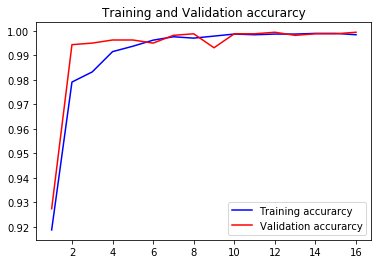

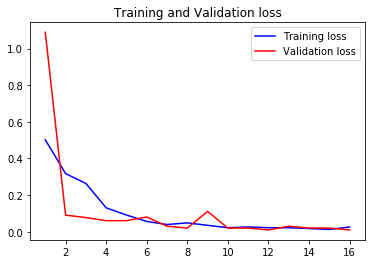

In [0]:
# plot the train and val curve
# get the details form the history object

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure()
# train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()

plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


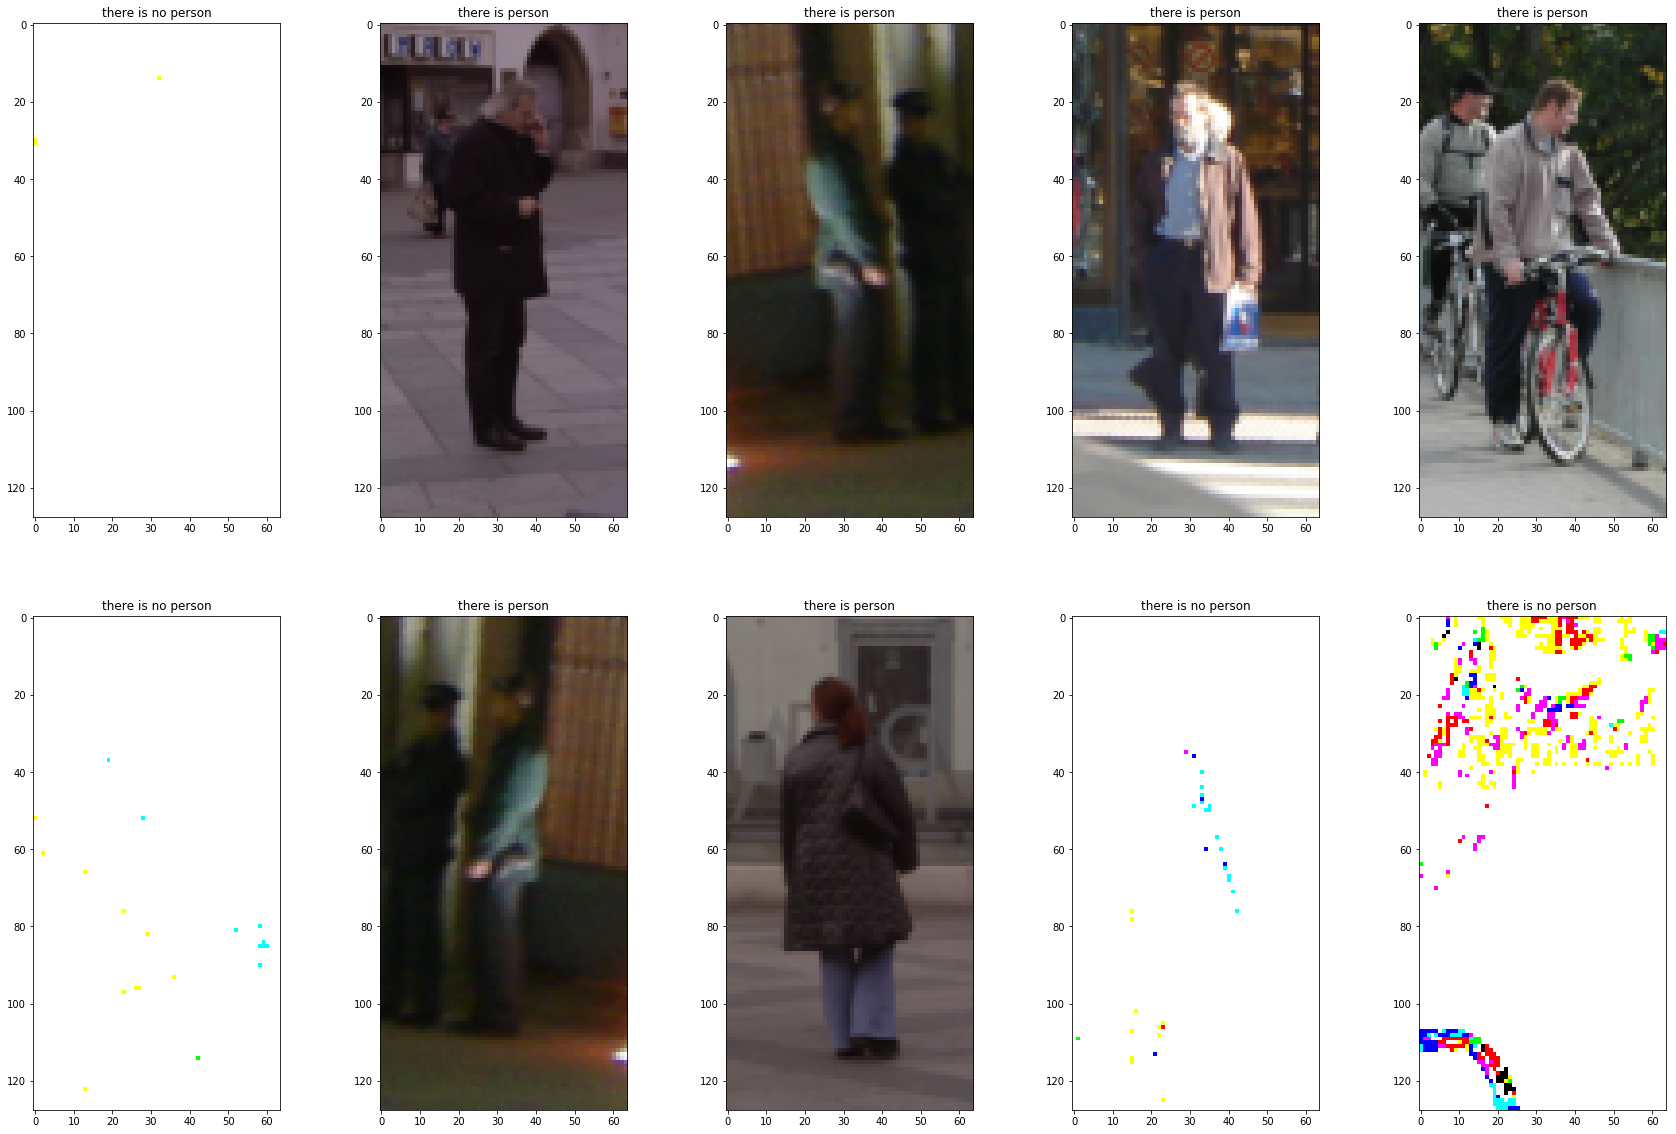

In [0]:
#test_datagen = ImageDataGenerator(rescale=1./255) 
test_datagen = ImageDataGenerator() 

#from keras.models import load_model
#loaded_model = load_model('model_keras_batch4_epochs16.h5')
#loaded_model.load_weights("model_wieghts_batch4_epochs16.h5")

i = 0
columns = 5
text_labels = []
plt.figure(figsize=(30,20))
for batch in test_datagen.flow(X_val, batch_size=1): # X_val instead of X_test
    pred = model.predict(batch)
    if pred > 0.5:
        text_labels.append('there is person')
    else:
        text_labels.append('there is no person')
    plt.subplot(5 / columns + 1, columns, i + 1)
    plt.title(text_labels[i])
    imgplot = plt.imshow(batch[0])
    i += 1
    if i % 10 == 0:
        break
plt.show()

# Detection of pedestrian

In [0]:
# define the sliding window:
def sliding_window(image, stepSize, windowSize):# image is the input, step size is the no.of pixels needed to skip and windowSize is the size of the actual window
    # slide a window across the image
    for y in range(0, image.shape[0], stepSize):# this line and the line below actually defines the sliding part and loops over the x and y coordinates
        for x in range(0, image.shape[1], stepSize):
            # yield the current window
            yield (x, y, image[y: y + windowSize[1], x:x + windowSize[0]])

In [0]:
%matplotlib inline

from PIL import Image, ImageDraw
from skimage.transform import pyramid_gaussian
from imutils.object_detection import non_max_suppression

# upload the saved svm model:
from keras.models import load_model
loaded_model = load_model('/content/drive/My Drive/Colab Notebooks/Project31/model_keras_batch4_epochs16 (1).h5')
loaded_model.load_weights("/content/drive/My Drive/Colab Notebooks/Project31/model_wieghts_batch4_epochs16 (1).h5")
model = loaded_model

# test the trained classifier on an image below!
scale = 0
detections = []

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:24: UserWarning: The default multichannel argument (None) is deprecated.  Please specify either True or False explicitly.  multichannel will default to False starting with release 0.16.
  warn('The default multichannel argument (None) is deprecated.  Please '


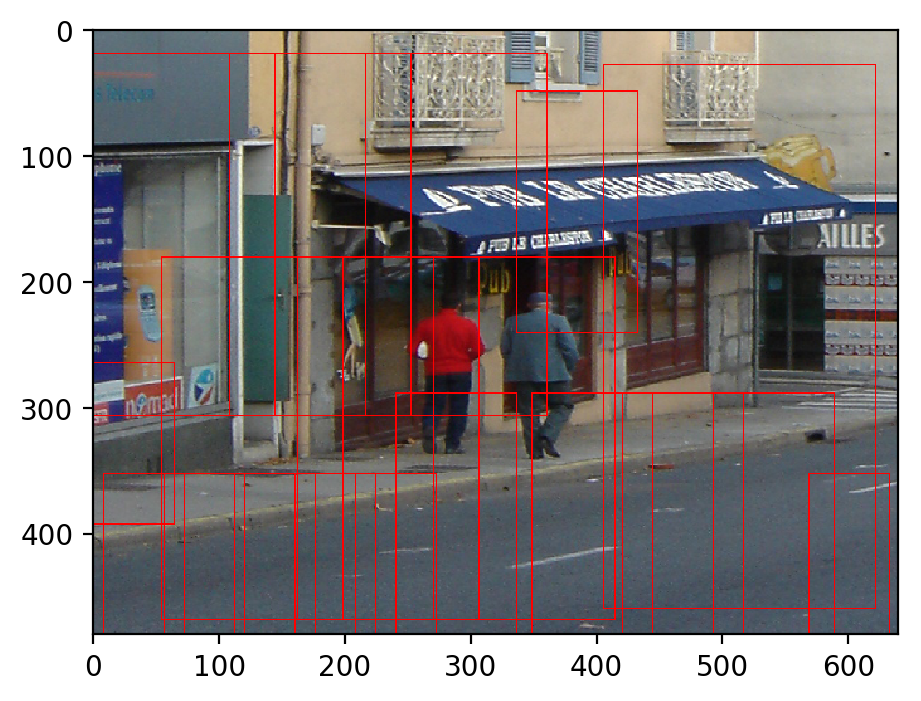

In [0]:
# read the image you want to detect the object in:
image = Image.open('INRIAPerson/Test/pos/crop001504.png')

# resize image if it is too big
image = image.resize((640,480)) 

# defining the size of the sliding window 
(winW, winH) = (64,128)
windowSize =(winW,winH)
downscale =1.5

# Apply sliding window:
for resized in pyramid_gaussian(image, downscale=1.5): # loop over each layer of the image that you take!
    # loop over the sliding window for each layer of the pyramid
    for (x,y,window) in sliding_window(resized, stepSize=8, windowSize=(winW,winH)):
        # if the window does not meet our desired window size, ignore it!
        if window.shape[0] != winH or window.shape[1] !=winW: # ensure the sliding window has met the minimum size requirement
            continue
        fds = np.expand_dims(window, axis=0)
        pred = model.predict(fds) # use the SVM model to make a prediction on the HOG features extracted from the window
        
        if pred > 0.5:
            detections.append((int(x * (downscale**scale)), int(y * (downscale**scale)), 
                                   int(windowSize[0]*(downscale**scale)), # create a list of all the predictions found
                                      int(windowSize[1]*(downscale**scale))))
    scale+=1
    
    
draw = ImageDraw.Draw(image)    
clone = resized.copy()

#for (x_tl, y_tl, _, w, h) in detections:
  #  draw.rectangle([x_tl, y_tl, x_tl + w, y_tl + h], outline=(255, 0, 0))
rects = np.array([[x, y, x + w, y + h] for (x, y, w, h) in detections]) # do nms on the detected bounding boxes



pick = non_max_suppression(rects, overlapThresh = 0.3)

# Start drawing rectangles for each possible detection
for (xA, yA, xB, yB) in pick:
    draw.rectangle([xA, yA, xB, yB], outline=(255, 0, 0))

#image.show()
#imshow(np.asarray(image))

plt.figure(dpi=200)
plt.imshow(image)